In [58]:
import nltk
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from nltk.tokenize import word_tokenize
import re
import os

In [14]:
df = pd.read_csv(r'Downloads/IMDB Dataset.csv')

In [15]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [18]:
df.shape

(50000, 2)

In [21]:
df.columns

Index(['review', 'sentiment'], dtype='object')

In [22]:
df.sentiment.value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [23]:
df.info

<bound method DataFrame.info of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

To make the DataFrame suitable for analysis by converting its sentiments values to integers:

In [24]:
df.sentiment = [1 if s == 'positive' else 0 for s in df.sentiment]
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
...,...,...
49995,I thought this movie did a down right good job...,1
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",0
49997,I am a Catholic taught in parochial elementary...,0
49998,I'm going to have to disagree with the previou...,0


### Data Preprocessing

First, we use regular expressions to make the following transformations to the reviews:

remove punctuation marks<br>
remove HTML tags<br>
remove URL's<br>
remove characters which are not letters or digits<br>
remove successive whitespaces<br>
convert to lower case<br>
strip whitespaces from the beginning and the end<br>

In [27]:
idx = random.randint(0, len(df)-1)

In [34]:
before_process = df.iloc[idx][0]  # Storing in "before_process" a random example of review before preprocessing

In [37]:
def process(x):
    x = re.sub('[,\.!?:()"]', '', x)
    x = re.sub('<.*?>', ' ', x)
    x = re.sub('http\S+', ' ', x)
    x = re.sub('[^a-zA-Z0-9]', ' ', x)
    x = re.sub('\s+', ' ', x)
    return x.lower().strip()

df['review'] = df['review'].apply(lambda x: process(x))
after_process = df.iloc[idx][0]

In [38]:
sw_set = set(nltk.corpus.stopwords.words('english'))

# Defining and applying the function "sw_remove" which remove stopwords from reviews
def sw_remove(x):
    words = nltk.tokenize.word_tokenize(x)
    filtered_list = [word for word in words if word not in sw_set]
    return ' '.join(filtered_list)

df['review'] = df['review'].apply(lambda x: sw_remove(x))
after_removal = sw_remove(after_process)

In [42]:
print('before preprocessing\n\n', before_process)
print('\n\nAfter preprocessing\n\n', after_process)
print('\n\nAfter preprocessing and stopwords removal\n\n', after_removal)

before preprocessing

 Only watched this to see Joe Morton in an early role and honestly wished I hadn't bothered, he can and has since, done much better than this crap. Cannot understand why anyone finds this kind of stupidity funny but each to his own; it is an absolute mess and not funny in the least. No wait, ONE line only was funny, where Mr Kent (Joe) and his family are having dinner with this nut job as he's been invited for dinner (Lord alone knows why). Pest to Mr Kent: You know what it's like dog, you've been there Mrs Kent: Not lately, Joe's expression was funny but that's it one line does not make a great comedy and this tat is so far away from being funny it should be consigned to the nearest trash cart, it's only good enough for that. Joe Morton - glad to see you don't appear in rubbish like this anymore; you are far superior and a great great actor.


After preprocessing

 only watched this to see joe morton in an early role and honestly wished i hadn t bothered he can a

### Data Splitting and Tokenization

In [43]:
from sklearn.model_selection import train_test_split

train_rev, test_rev, train_sent, test_sent = train_test_split(df['review'], df['sentiment'], test_size=0.1, random_state=42)

we use the Tokenizer class from keras.preprocessing.text module to create a dictionary of the "dict_size" most frequent words present in the reviews (a unique integer is assigned to each word), and we print some of its attributes. The index of the Tokenizer is computed the same way no matter how many most frequent words we use later

In [46]:
from keras.preprocessing.text import Tokenizer

dict_size = 35000
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(df['review'])

print('Dictionary size : ', dict_size)
print('\n\nLength of Tokenizer : ', len(tokenizer.word_index))
print('\n\nNumber of documents tokenizer trained on : ', tokenizer.document_count)
print('\n\nFirst 20 entries of tokenizer index \n\n', list(tokenizer.word_index.items())[:20])


Dictionary size :  35000


Length of Tokenizer :  125791


Number of documents tokenizer trained on :  50000


First 20 entries of tokenizer index 

 [('movie', 1), ('film', 2), ('one', 3), ('like', 4), ('good', 5), ('time', 6), ('even', 7), ('would', 8), ('really', 9), ('story', 10), ('see', 11), ('well', 12), ('much', 13), ('get', 14), ('bad', 15), ('people', 16), ('great', 17), ('also', 18), ('first', 19), ('made', 20)]


We use the texts_to_sequences() function of the Tokenizer class to convert the training reviews and test reviews to lists of sequences of integers (tokens) "train_rev_tokens" and "test_rev_tokens", and we store in the numpy array "seq_lengths" the lengths of the sequences included in "train_rev_tokens" and "test_rev_tokens".

In [49]:
train_rev_tokens = tokenizer.texts_to_sequences(train_rev)

In [50]:
test_rev_tokens = tokenizer.texts_to_sequences(test_rev)

In [52]:
seq_lengths = np.array([len(sequence) for sequence in train_rev_tokens])

If the lengths of the sequences were normally distributed, then a given length could be considered small or large when outside the interval and lengths not belonging to this interval would only represent 5% of the elements of seq_lengths . Here, we follow this heuristics, and thus define an upper bound for the length of sequences accordingly. We are using on training set to define the upper bound to avoid any data leakage or look-ahead bias

In [54]:
# Storing in "upper_bound" our chosen upper bound for the length of sequences
# Computing the percentage of lengths smaller or equal than "upper_bound"

upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)

In [55]:
upper_bound

291

In [56]:
percentage

94.55888888888889

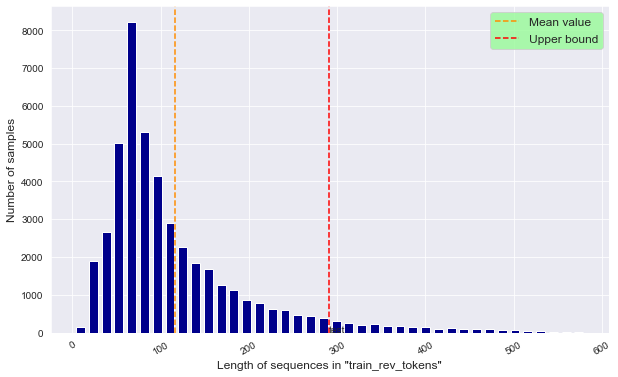

In [59]:
with sns.axes_style("darkgrid"):

    _, hist = plt.subplots(figsize=(10,6))
    hist.hist(seq_lengths[seq_lengths < 2*upper_bound], color='darkblue', bins=40, rwidth=0.7)
    hist.axvline(np.mean(seq_lengths), color='darkorange', linestyle='--', label='Mean value')
    hist.axvline(upper_bound, color='r', linestyle='--', label='Upper bound')

    plt.xlabel('Length of sequences in "train_rev_tokens"', size='large')
    plt.ylabel('Number of samples', size='large')
    plt.text(upper_bound, 0, 'test')
    plt.legend(fontsize='large', facecolor='palegreen')
    plt.xticks(rotation=30)
    plt.show()


The value of upper_bound is 291 and the percentage of sequences in "train_rev_tokens" of length smaller or equal than upper_bound is 94.56%.


Using the pad_sequences() function from keras.preprocessing.sequence module, we transform "train_rev_tokens" and "test_rev_tokens" into 2D numpy arrays of shape (number of sequences, upper_bound). Sequences of length smaller (resp. larger) than "upper_bound" are extended (resp. truncated) to get length equal to "upper_bound".

In [60]:
from keras.preprocessing.sequence import pad_sequences

train_rev_pad = pad_sequences(train_rev_tokens, maxlen=upper_bound)
test_rev_pad = pad_sequences(test_rev_tokens, maxlen=upper_bound)


In [61]:
train_rev_pad.shape

(45000, 291)

In [62]:
test_rev_pad.shape

(5000, 291)

### LSTM Model

In [63]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dropout, Dense

In the model that we use, we set the following parameters:

the output dimension of the Embedding layer (dimension of the vector space containing the word embeddings) is "output_dim"<br>
the number of units of the LSTM layer is "units_lstm"<br>
the dropout rate of the Dropout layer is "r"<br>
the activation function of the final Dense layer is sigmoid (this is a natural choice since the output of the model should be a number between 0, for negative reviews, and 1, for positive reviews)


In [65]:
output_dim = 14
units_lstm = 16
r = 0.8

model = Sequential()
model.add(Embedding(input_dim=dict_size, output_dim=output_dim, input_length=upper_bound))
model.add(LSTM(units_lstm))
model.add(Dropout(r))
model.add(Dense(1, activation='sigmoid'))

In [66]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 291, 14)           490000    
                                                                 
 lstm (LSTM)                 (None, 16)                1984      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 492,001
Trainable params: 492,001
Non-trainable params: 0
_________________________________________________________________


In [68]:
model.compile(optimizer='adam', loss='bce', metrics='accuracy') #binary cross-entropy (bce) between true labels and predicted labels as loss to minimise during training process

In [69]:
validation_split = 0.1
batch_size = 512
epochs = 4

fitted = model.fit(train_rev_pad, train_sent, validation_split=validation_split,
                   batch_size=batch_size, epochs=epochs, shuffle=True)

Epoch 1/4
80/80 [==============================] - 29s 316ms/step - loss: 0.6581 - accuracy: 0.6353 - val_loss: 0.5257 - val_accuracy: 0.8164
Epoch 2/4
80/80 [==============================] - 23s 288ms/step - loss: 0.4351 - accuracy: 0.8557 - val_loss: 0.3223 - val_accuracy: 0.8960
Epoch 3/4
80/80 [==============================] - 25s 316ms/step - loss: 0.3060 - accuracy: 0.9082 - val_loss: 0.2656 - val_accuracy: 0.9002
Epoch 4/4
80/80 [==============================] - 24s 297ms/step - loss: 0.2408 - accuracy: 0.9333 - val_loss: 0.2548 - val_accuracy: 0.9024


In [70]:
result= model.evaluate(test_rev_pad, test_sent)

157/157 [==============================] - 4s 23ms/step - loss: 0.2498 - accuracy: 0.9018


we test the trained model on a randomly chosen review from the test set. We display the original review, the sentiment predicted by the model with its probability, and the original (correct) sentiment

In [72]:
# Storing in DataFrame "df_original" the original reviews and sentiments

df_original = pd.read_csv(r'Downloads/IMDB Dataset.csv')

# Choosing randomly a review and its sentiment in the test data

idx_test = random.randint(0, len(test_sent)-1)
idx_original = test_rev.index[idx_test]
(original_rev, original_sent) = df_original.iloc[idx_original]

# Storing in "prediction_sent" the predicted sentiment of the chosen review
# Storing in "probability" the probability of the predicted sentiment of the chosen review

prediction = model.predict(test_rev_pad)[idx_test][0]
prediction_sent = 'positive' if prediction >= 0.5 else 'negative'
probability = round(prediction if prediction >= 0.5 else 1-prediction, 2)


In [73]:
original_rev

"Not like I went in expecting a lot out of it, but I was at least hoping for a fun dumb big budget movie. This isn't even that. This item ranks in the bottom half of all the vampire movies I've ever seen (and believe me, I've seen a lot of them). Bad acting, zero characterization, little to no thought, almost non-existent plot (and that that's there you can drive semi-trucks through the holes in). Sure, it has action and is loud, and has more action, and more noise, and blood, and action... These things alone do not make a good (or even halfway decent) movie. Beats me how some people can say this is the best vampire movie ever made--all I can assume is they haven't seen many. I suggest seeing Near Dark instead."

In [74]:
prediction_sent

'negative'

In [75]:
original_sent

'negative'